## Importing necessary libaries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn import tree

## Load machine failure file

In [2]:
data = pd.read_csv('machine_failure.csv')
data

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


## Exploratory analysis

In [3]:
data = pd.get_dummies(data, columns=['Type', ])
data.head()

,UDI,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,1,M14860,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,False,False,True
1,2,L47181,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,False,True,False
2,3,L47182,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,False,True,False
3,4,L47183,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,False,True,False
4,5,L47184,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,False,True,False


In [4]:
data.dtypes

UDI                          int64
Product ID                  object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
Type_H                        bool
Type_L                        bool
Type_M                        bool
dtype: object

## Consolidating types of machine failure into the machine failure column

In [5]:
data['Machine failure'] = np.where((data['TWF'] == 1) | (data['HDF'] == 1) | (data['PWF'] == 1) | (data['OSF'] == 1), 1, 0)

cleaned_data = data.drop(['UDI','Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)

cleaned_data

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,False,False,True
1,298.2,308.7,1408,46.3,3,0,False,True,False
2,298.1,308.5,1498,49.4,5,0,False,True,False
3,298.2,308.6,1433,39.5,7,0,False,True,False
4,298.2,308.7,1408,40.0,9,0,False,True,False
...,...,...,...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0,False,False,True
9996,298.9,308.4,1632,31.8,17,0,True,False,False
9997,299.0,308.6,1645,33.4,22,0,False,False,True
9998,299.0,308.7,1408,48.5,25,0,True,False,False


## Building Ridge regression model

In [6]:
#Load the predictor and target variables
X = cleaned_data.drop(columns=['Machine failure'])
y = cleaned_data['Machine failure']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize (scale) the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a RidgeCV model with alpha optimization using cross-validation
alphas = [0.01, 0.1, 1.0, 10.0]  # List of alpha values to test
ridge = RidgeCV(alphas=alphas, store_cv_values=True)

# Fit the Ridge regression model to the training data
ridge.fit(X_train_scaled, y_train)

# Print the best alpha determined by cross-validation
print("Best alpha:", ridge.alpha_)

# Evaluate the model on the test data
y_pred = ridge.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Data:", mse)

Best alpha: 1.0
Mean Squared Error on Test Data: 0.025101684998599487


## Analyzing feature weights

In [7]:
feature_weights = ridge.coef_
feature_names = X.columns

print("Feature Weights (Coefficients):")
for feature, weight in zip(feature_names, feature_weights):
    print(f"{feature}: {weight:.4f}")

Feature Weights (Coefficients):
Air temperature [K]: 0.0426
Process temperature [K]: -0.0300
Rotational speed [rpm]: 0.0924
Torque [Nm]: 0.1145
Tool wear [min]: 0.0200
Type_H: -0.0040
Type_L: 0.0031
Type_M: -0.0007


## Building Lasso regression model

In [8]:
#Load the predictor and target variables
X = cleaned_data.drop(columns=['Machine failure'])
y = cleaned_data['Machine failure']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize (scale) the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a LassoCV model with alpha optimization using cross-validation
alphas = [0.01, 0.1, 1.0, 10.0]  # List of alpha values to test
lasso = LassoCV(alphas=alphas, cv=5)

# Fit the Lasso regression model to the training data
lasso.fit(X_train_scaled, y_train)

# Print the best alpha determined by cross-validation
print("Best alpha:", lasso.alpha_)

# Evaluate the model on the test data
y_pred = lasso.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Data:", mse)

Best alpha: 0.01
Mean Squared Error on Test Data: 0.02709712063763147


## Analyzing feature weights

In [9]:
feature_weights = lasso.coef_
feature_names = X.columns

print("Feature Weights (Coefficients):")
for feature, weight in zip(feature_names, feature_weights):
    print(f"Feature {feature}: {weight:.4f}")

Feature Weights (Coefficients):
Feature Air temperature [K]: 0.0074
Feature Process temperature [K]: 0.0000
Feature Rotational speed [rpm]: 0.0127
Feature Torque [Nm]: 0.0350
Feature Tool wear [min]: 0.0097
Feature Type_H: -0.0000
Feature Type_L: 0.0000
Feature Type_M: -0.0000


## Building Decision Tree

In [10]:
# Create the classifier, fit it on the training data and make predictions on the test set
clf = DecisionTreeClassifier(criterion='entropy')

clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [12]:
# Make predictions for test data
y_pred = clf.predict(X_test) 
y_pred_flt = np.array(y_pred).flatten()
y_test_flt = np.array(y_test).flatten()
y_train_flt = np.array(y_train).flatten()

### Check the predictive performances

In [13]:
# Calculate accuracy 
acc = accuracy_score(y_test,y_pred) * 100
print('Accuracy is : {0}'.format(acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is : {0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test_flt, y_pred_flt, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy is : 98.26666666666667

AUC is : 0.86

Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,2882,28,2910
1,24,66,90
All,2906,94,3000


## Build Decision Tree

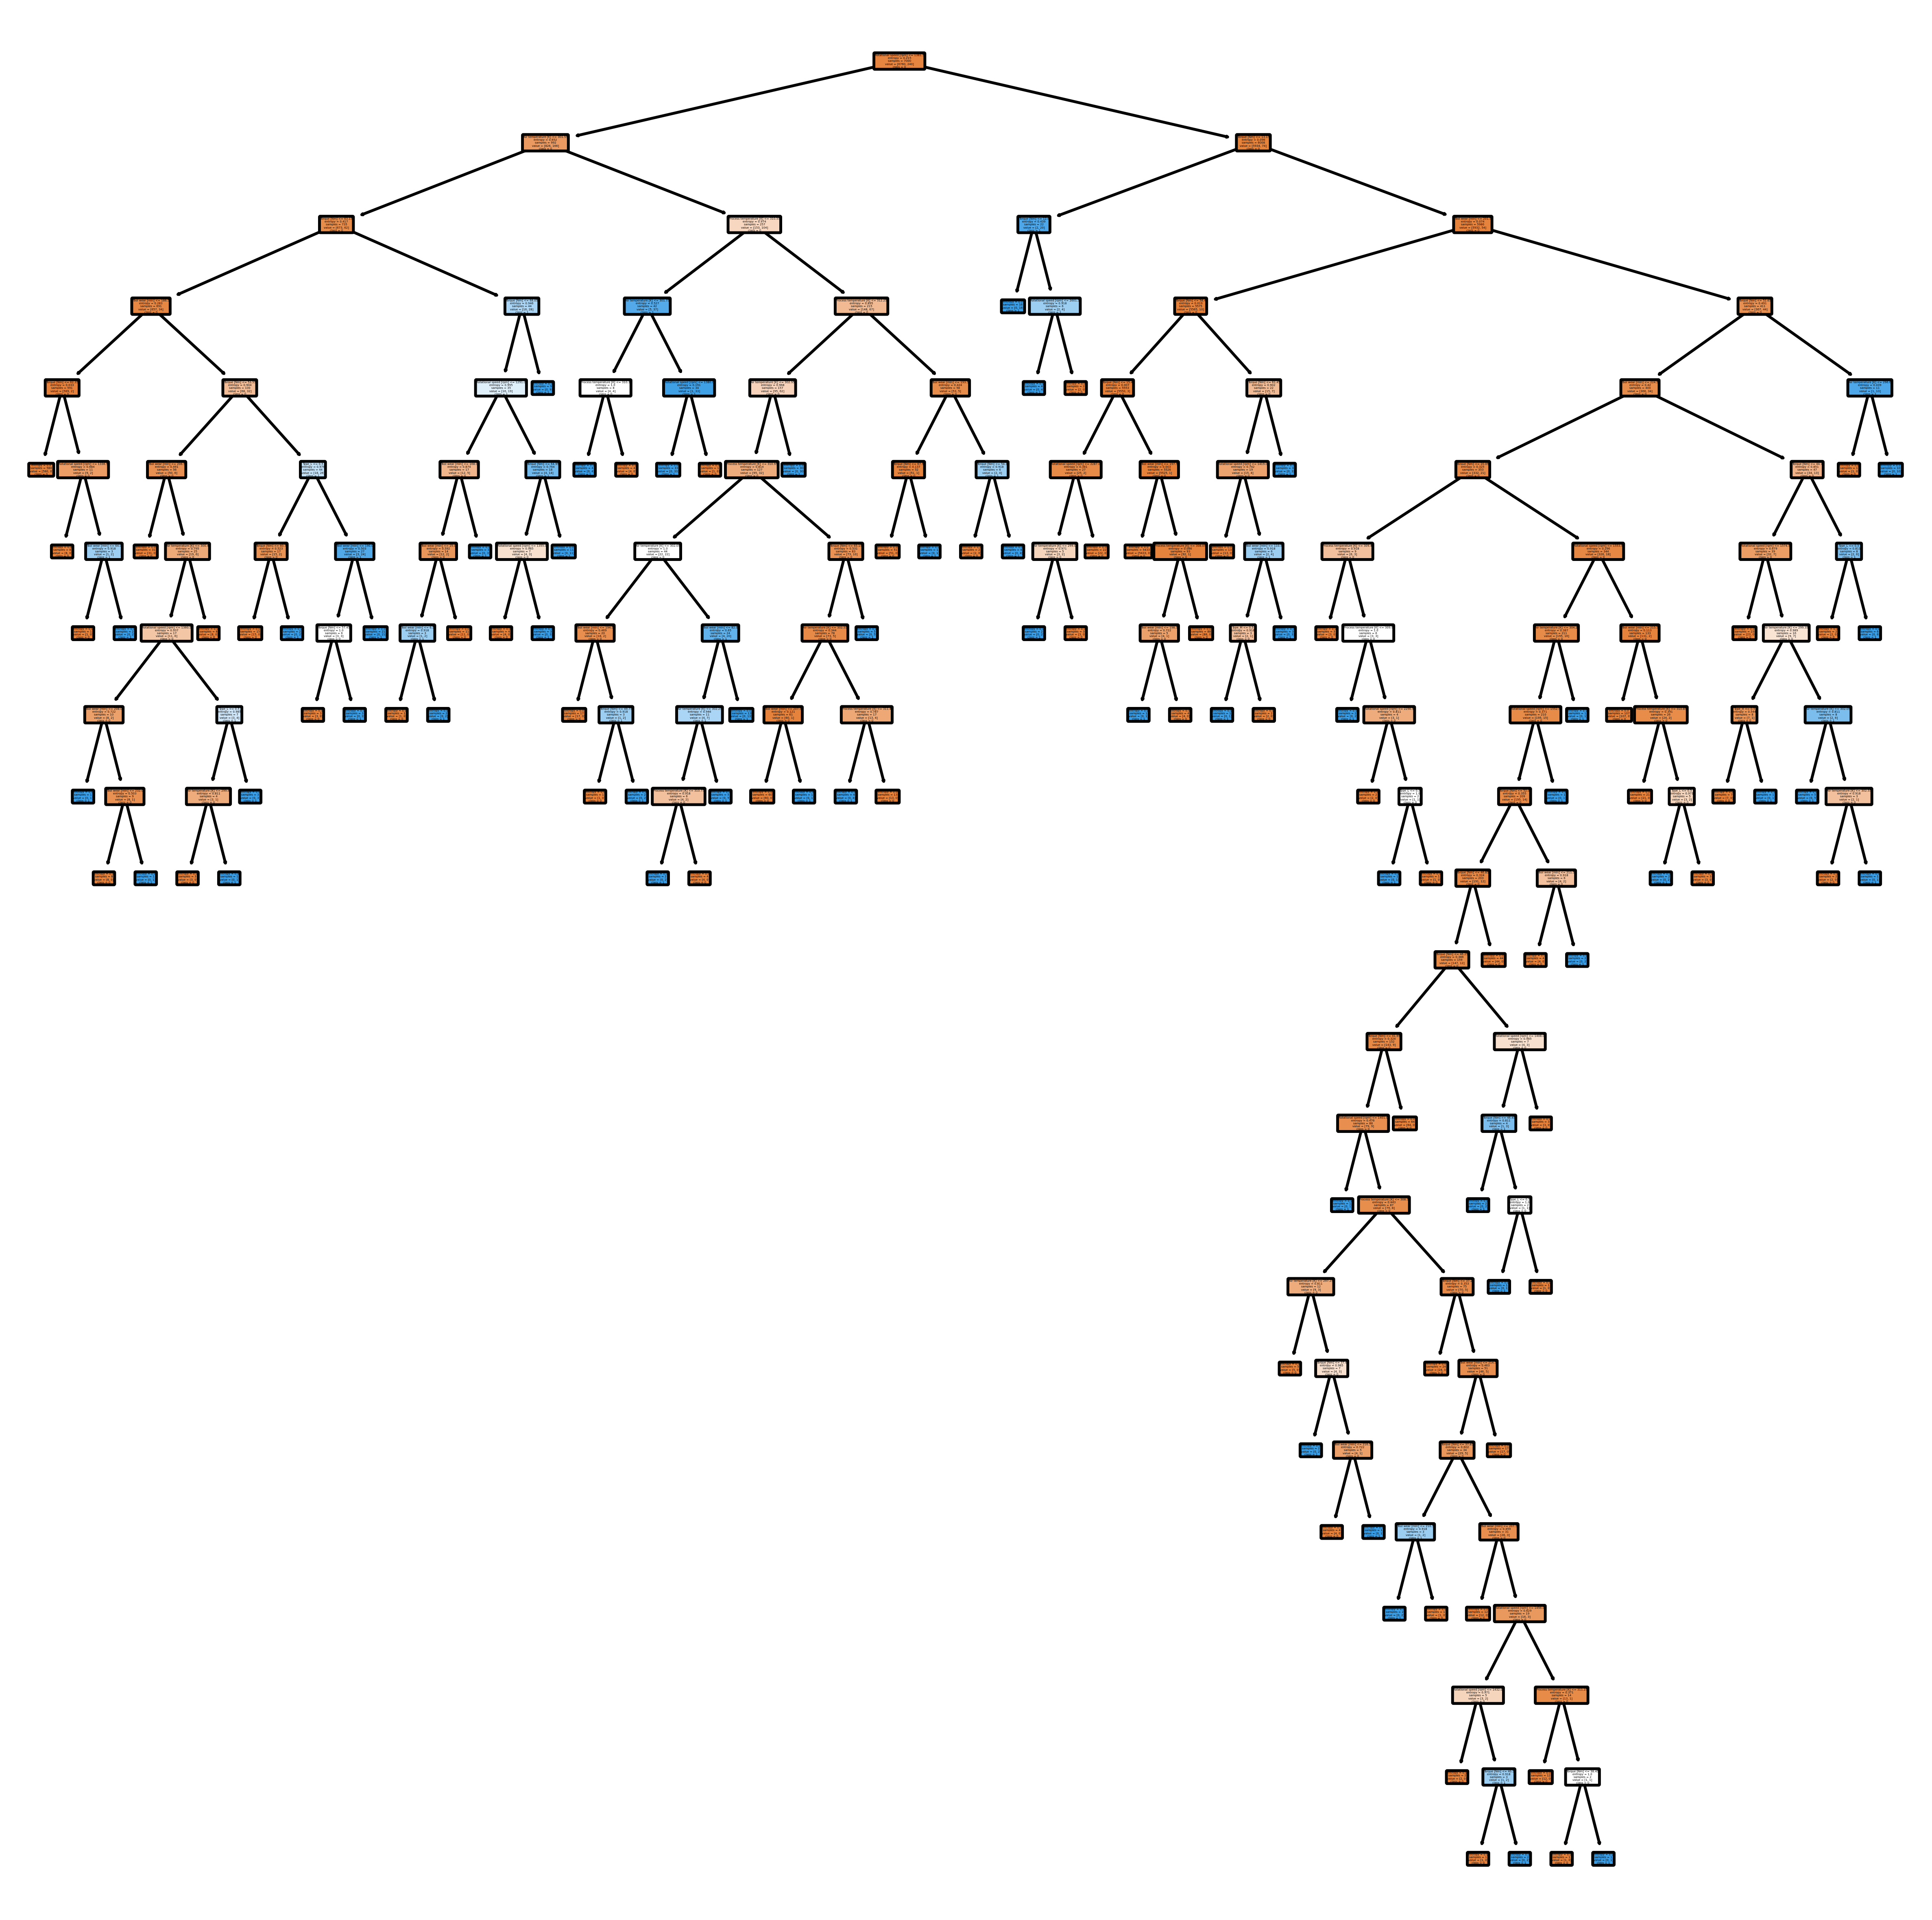

In [19]:
# Plot and show decision tree
plt.figure(figsize=(12,12), dpi=500)
tree.plot_tree(clf, 
               feature_names=X.columns.tolist(),
               class_names=np.unique(y).astype('str').tolist(),
               filled=True, rounded=True)
plt.show()

## Create an Isolation Forest Model

In [20]:
# Create an Isolation Forest model
isolation_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model to the training data
isolation_forest.fit(X_train)

# Predict anomalies in the test data
y_pred_iso = isolation_forest.predict(X_test)

## Create One-class Support Machine Model

In [21]:
# Create a One-Class SVM model
one_class_svm = OneClassSVM(nu=0.05)

# Fit the model to the training data (Note: One-Class SVM is an unsupervised method)
one_class_svm.fit(X_train)

# Predict anomalies in the test data
y_pred_svm = one_class_svm.predict(X_test)

## Evaluation Metrics for Isolation modela and SVM

Isolation Forest - Precision: 0.00, Recall: 0.02
One-Class SVM - Precision: 0.00, Recall: 0.02


c:\Users\takinlabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to -1) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\takinlabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\takinlabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to -1) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\takinlabi\AppData\Local\Programs\Python\Python311\Lib

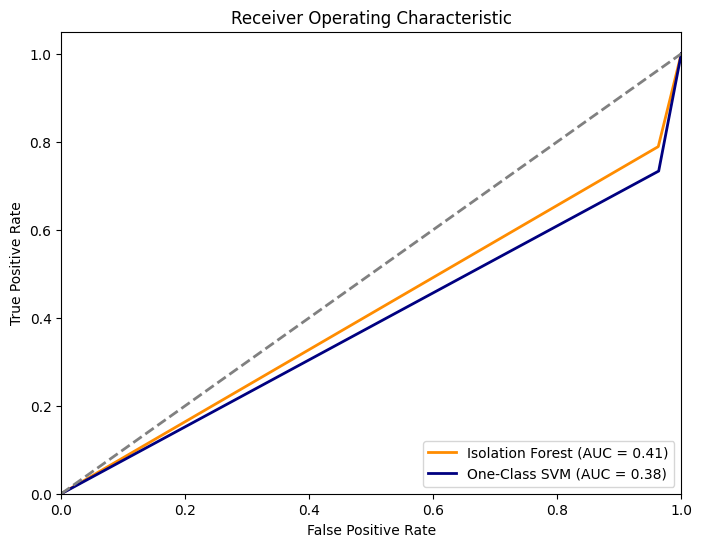

In [22]:
# Calculate precision and recall
precision_iso = precision_score(y_test, y_pred_iso, pos_label=-1, average= 'weighted')
recall_iso = recall_score(y_test, y_pred_iso, pos_label=-1, average= 'weighted')

precision_svm = precision_score(y_test, y_pred_svm, pos_label=-1, average= 'weighted')
recall_svm = recall_score(y_test, y_pred_svm, pos_label=-1, average= 'weighted')

print(f"Isolation Forest - Precision: {precision_iso:.2f}, Recall: {recall_iso:.2f}")
print(f"One-Class SVM - Precision: {precision_svm:.2f}, Recall: {recall_svm:.2f}")

# Calculate ROC curve and AUC
fpr_iso, tpr_iso, _ = roc_curve(y_test, y_pred_iso)
roc_auc_iso = auc(fpr_iso, tpr_iso)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_iso, tpr_iso, color='darkorange', lw=2, label=f'Isolation Forest (AUC = {roc_auc_iso:.2f})')
plt.plot(fpr_svm, tpr_svm, color='navy', lw=2, label=f'One-Class SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()